In [1]:
# all imports come here
from faster_whisper import WhisperModel
import pandas as pd
import torch
import torchaudio
from statistics import mean, median, mode
import openpyxl
import warnings
import numpy as np
import time
import torchcrepe
from scipy.io import wavfile
import pesto
import crepe
import resampy


start = time.time()
warnings.filterwarnings("ignore")

/speech/dbwork/mul/spielwiese4/students/desengus/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# all major variables are here
model_size = "medium.en"
music_file_path = '/speech/dbwork/mul/spielwiese3/students/debaumas/datasets/tency_mastering_supervised_dry_wet_v2_22050_16bit/test/dry/0.wav'
sample_rate_speech = 16000
step_size_for_pitch = 10.
vad_threshold = 0.3 # speech probability - if more then speech else no speech
confidence_pesto = 0.1
num_sample = 10 # pesto computes 10 ms per sample so for a window of 100ms we need 10 samples as 10*10ms = 100ms
timestamp_for_sampling = step_size_for_pitch*num_sample/1000

In [3]:
number_per_sample = 200 #200*100ms = 20sec sampling

In [4]:
# generate the modified start and the end times of the words said
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad')
(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils

wav = read_audio(music_file_path, sampling_rate=sample_rate_speech)
speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=sample_rate_speech, threshold=vad_threshold)

total_datapoints = round(list(wav.shape)[0]/sample_rate_speech,0)

Using cache found in /home/desengus/.cache/torch/hub/snakers4_silero-vad_master


In [5]:
# Run on GPU with FP16
#model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
faster_whisper_model = WhisperModel(model_size, compute_type='int8',device="cpu")
# or run on CPU with INT8
# model = WhisperModel(model_size, device="cpu", compute_type="int8")


In [6]:
len(speech_timestamps)

1

In [7]:
tmp_x = len(speech_timestamps)
word_timings = pd.DataFrame(columns = ['start','end','words'])
start = []
end = []
words = []

for i in range(tmp_x):
  print(i)
  save_audio('/speech/dbwork/mul/spielwiese4/students/desengus/'+music_file_path.split("/")[-1][:-4]+'.wav',
           wav[speech_timestamps[i]['start']:speech_timestamps[i]['end']], sampling_rate=sample_rate_speech)
  segments, _ = faster_whisper_model.transcribe('/speech/dbwork/mul/spielwiese4/students/desengus/'+music_file_path.split("/")[-1][:-4]+'.wav', word_timestamps=True)
  for segment in segments:
    for word in segment.words:
      start.append(round(word.start+speech_timestamps[i]['start']/sample_rate_speech,3))
      end.append(round(word.end+speech_timestamps[i]['end']/sample_rate_speech, 3))
      words.append(word.word)

      #print(round(word.start+speech_timestamps[i]['start']/sample_rate_speech,4), round(word.end+speech_timestamps[i]['end']/sample_rate_speech, 4), word.word)

word_timings['start'] = start
word_timings['end'] = end
word_timings['words'] = words


0


In [8]:
# predict the pitch of your audio tensors directly within your own Python code
audio_pesto, sample_rate_pesto = torchaudio.load(music_file_path)
audio_pesto = torchaudio.functional.resample(audio_pesto, orig_freq=sample_rate_pesto, new_freq=sample_rate_speech)
timesteps_pesto, pitch_pesto, confidence_pesto, activations_pesto = pesto.predict(audio_pesto, sample_rate_speech, step_size=step_size_for_pitch)


In [9]:
sample_rate_pesto

22050

In [10]:
sample_rate, audio = wavfile.read(music_file_path)
audio = resampy.resample(audio, sr_orig=sample_rate, sr_new=sample_rate_speech)
timesteps_crepe, pitch_crepe, confidence_crepe, activations_crepe = crepe.predict(audio, sample_rate_speech, step_size=step_size_for_pitch)


2023-11-21 10:45:10.762330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 10:45:10.762367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 10:45:10.763772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 10:45:10.773289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 10:45:12.971976: W tensorflow/compiler/tf2

  13/1381 [..............................] - ETA: 13s 

2023-11-21 10:45:18.891322: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-11-21 10:45:18.931818: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1381/1381 [==============================] - 16s 10ms/step


In [11]:
sample_rate

22050

In [12]:
sample_rate_speech

16000

In [13]:
word_timings

,start,end,words
0,351.298,352.25,you


In [14]:
timesteps_result_crepe = [round(tensor.item(),2) for tensor in timesteps_crepe]
pitch_result_crepe = [round(tensor.item(),4) for tensor in pitch_crepe]
confidence_result_crepe = [round(tensor.item(),4) for tensor in confidence_crepe]
df_pitch_crepe = pd.DataFrame([timesteps_result_crepe,pitch_result_crepe,confidence_result_crepe])
df_pitch_crepe = df_pitch_crepe.T
df_pitch_crepe.columns = ['timesteps_crepe','pitch_crepe','confidence_crepe']

In [15]:
timesteps_result_pesto = [round(tensor.item(),2) for tensor in timesteps_pesto]
pitch_result_pesto = [round(tensor.item(),4) for tensor in pitch_pesto]
confidence_result_pesto = [round(tensor.item(),4) for tensor in confidence_pesto]
df_pitch_pesto = pd.DataFrame([timesteps_result_pesto,pitch_result_pesto,confidence_result_pesto])
df_pitch_pesto = df_pitch_pesto.T
df_pitch_pesto.columns = ['timesteps_pesto','pitch_pesto','confidence_pesto']

In [16]:
df_pitch_crepe

,timesteps_crepe,pitch_crepe,confidence_crepe
0,0.00,547.1256,0.1413
1,0.01,547.1256,0.1413
2,0.02,547.1256,0.1413
3,0.03,547.1256,0.1413
4,0.04,547.1256,0.1413
...,...,...,...
44178,441.78,547.1256,0.1413
44179,441.79,547.1256,0.1413
44180,441.80,547.1256,0.1413
44181,441.81,547.1256,0.1413


In [17]:
df_pitch_pesto

,timesteps_pesto,pitch_pesto,confidence_pesto
0,0.00,30.3333,0.0000
1,0.01,29.0000,0.0001
2,0.02,26.6667,0.0002
3,0.03,26.6667,0.0005
4,0.04,27.0000,0.0008
...,...,...,...
44178,441.78,40.6667,0.0270
44179,441.79,41.0000,0.0261
44180,441.80,41.0000,0.0254
44181,441.81,29.0000,0.0250


In [18]:
# # just for info

# import matplotlib.pyplot as plt

# df_pitch['pitch_norm']= (df_pitch['pitch'] - df_pitch['pitch'].min()) / (df_pitch['pitch'].max() - df_pitch['pitch'].min())
# df_pitch['confidence_norm'] = (df_pitch['confidence'] - df_pitch['confidence'].min()) / (df_pitch['confidence'].max() - df_pitch['confidence'].min())


# plt.plot(df_pitch['timesteps'], df_pitch['pitch_norm'], label='Data 1', marker='o')
# plt.plot(df_pitch['timesteps'], df_pitch['confidence_norm']>0.1, label='Data 2', marker='x')


In [19]:
# (df_pitch['confidence_norm'] > 0.2).mean() * 100

In [20]:
# df_pitch = df_pitch[df_pitch['confidence_norm'] >= confidence_pesto]
# df_pitch = df_pitch.reset_index(drop=True)

In [21]:
# set the end based on the start of the next word such that there is no overlap
for i in range(len(word_timings) - 1):
    if word_timings.at[i, 'end'] > word_timings.at[i + 1, 'start']:
        word_timings.at[i, 'end'] = word_timings.at[i + 1, 'start']



In [22]:
word_timings

,start,end,words
0,351.298,352.25,you


In [23]:
word_timings['start'] = round(word_timings['start'],1)
word_timings['end'] = round(word_timings['end'],1)
word_timings['pitches_pesto'] = pd.Series(dtype='object')
word_timings['mean_pitches_pesto'] = pd.Series(dtype='object')
word_timings['median_pitches_pesto'] = pd.Series(dtype='object')
word_timings['mode_pitches_pesto'] = pd.Series(dtype='object')
word_timings['pitches_crepe'] = pd.Series(dtype='object')
word_timings['mean_pitches_crepe'] = pd.Series(dtype='object')
word_timings['median_pitches_crepe'] = pd.Series(dtype='object')
word_timings['mode_pitches_crepe'] = pd.Series(dtype='object')
word_timings['samples'] = (word_timings['end']-word_timings['start'])/timestamp_for_sampling
word_timings['samples'] = word_timings['samples'].round(0).astype('int')
word_timings['act_start'] = pd.Series(dtype='object')
word_timings['act_end'] = pd.Series(dtype='object')
word_timings['word_index'] = word_timings.index+1
word_timings['word_index'] = word_timings['word_index'].astype(str)

word_timings['mean_note_pesto'] = pd.Series(dtype='object')
word_timings['median_note_pesto'] = pd.Series(dtype='object')
word_timings['mode_note_pesto'] = pd.Series(dtype='object')
word_timings['mean_note_crepe'] = pd.Series(dtype='object')
word_timings['median_note_crepe'] = pd.Series(dtype='object')
word_timings['mode_note_crepe'] = pd.Series(dtype='object')


In [24]:
word_timings['word_index']

0    1
Name: word_index, dtype: object

In [25]:
# Duplicate rows based on the 'Value' column
word_timings_expanded = word_timings.loc[word_timings.index.repeat(word_timings['samples'])]

# Reset index to get a new DataFrame with duplicated rows
word_timings_expanded = word_timings_expanded.reset_index(drop=True)

In [26]:
word_timings_expanded.shape[0]

9

In [27]:
tmp_start = word_timings_expanded['start'][0]
word_timings_expanded['act_start'][0] = tmp_start
word_timings_expanded['act_end'][0] = tmp_start + timestamp_for_sampling
for i in range(1,word_timings_expanded.shape[0]):
    if tmp_start == word_timings_expanded['start'][i]:
        word_timings_expanded['act_start'][i] = (word_timings_expanded['act_end'][i-1]).round(1)
        word_timings_expanded['act_end'][i] = (word_timings_expanded['act_start'][i]+timestamp_for_sampling).round(1)
    else:
        tmp_start = word_timings_expanded['start'][i]
        word_timings_expanded['act_start'][i] = (tmp_start).round(1)
        word_timings_expanded['act_end'][i] = (word_timings_expanded['act_start'][i]+timestamp_for_sampling).round(1)

In [28]:
word_timings_expanded

,start,end,words,pitches_pesto,mean_pitches_pesto,median_pitches_pesto,mode_pitches_pesto,pitches_crepe,mean_pitches_crepe,median_pitches_crepe,...,samples,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
0,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.3,351.4,1,NaN,NaN,NaN,NaN,NaN,NaN
1,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.4,351.5,1,NaN,NaN,NaN,NaN,NaN,NaN
2,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.5,351.6,1,NaN,NaN,NaN,NaN,NaN,NaN
3,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.6,351.7,1,NaN,NaN,NaN,NaN,NaN,NaN
4,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.7,351.8,1,NaN,NaN,NaN,NaN,NaN,NaN
5,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.8,351.9,1,NaN,NaN,NaN,NaN,NaN,NaN
6,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,351.9,352.0,1,NaN,NaN,NaN,NaN,NaN,NaN
7,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,352.0,352.1,1,NaN,NaN,NaN,NaN,NaN,NaN
8,351.3,352.2,you,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,352.1,352.2,1,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
for i in range(word_timings_expanded.shape[0]):
  start = word_timings_expanded['act_start'][i]
  end = word_timings_expanded['act_end'][i]
  pitch_pesto = []
  pitch_crepe = []
  print(i)
  for j in range(df_pitch_pesto.shape[0]):
    if start <= df_pitch_pesto['timesteps_pesto'][j] <= end:
      pitch_pesto.append(df_pitch_pesto['pitch_pesto'][j])

  for j in range(df_pitch_crepe.shape[0]):
    if start <= df_pitch_crepe['timesteps_crepe'][j] <= end:
      pitch_crepe.append(df_pitch_crepe['pitch_crepe'][j])

  word_timings_expanded['pitches_pesto'][i] = pitch_pesto
  word_timings_expanded['pitches_crepe'][i] = pitch_crepe




0
1
2
3
4
5
6
7
8


In [30]:
word_timings_expanded[45:46]

,start,end,words,pitches_pesto,mean_pitches_pesto,median_pitches_pesto,mode_pitches_pesto,pitches_crepe,mean_pitches_crepe,median_pitches_crepe,...,samples,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe


In [31]:
for i in range(word_timings_expanded.shape[0]):
  #print(i)
  if word_timings_expanded['pitches_pesto'][i] ==[]:
    word_timings_expanded['mean_pitches_pesto'][i] = 0
    word_timings_expanded['median_pitches_pesto'][i] = 0
    word_timings_expanded['mode_pitches_pesto'][i] = 0
  else:
    word_timings_expanded['mean_pitches_pesto'][i] = mean(word_timings_expanded['pitches_pesto'][i])
    word_timings_expanded['median_pitches_pesto'][i] = median(word_timings_expanded['pitches_pesto'][i])
    word_timings_expanded['mode_pitches_pesto'][i] = mode(word_timings_expanded['pitches_pesto'][i])

  if word_timings_expanded['pitches_crepe'][i] ==[]:
    word_timings_expanded['mean_pitches_crepe'][i] = 0
    word_timings_expanded['median_pitches_crepe'][i] = 0
    word_timings_expanded['mode_pitches_crepe'][i] = 0
  else:
    word_timings_expanded['mean_pitches_crepe'][i] = mean(word_timings_expanded['pitches_crepe'][i])
    word_timings_expanded['median_pitches_crepe'][i] = median(word_timings_expanded['pitches_crepe'][i])
    word_timings_expanded['mode_pitches_crepe'][i] = mode(word_timings_expanded['pitches_crepe'][i])
    

In [32]:
word_timings_expanded

,start,end,words,pitches_pesto,mean_pitches_pesto,median_pitches_pesto,mode_pitches_pesto,pitches_crepe,mean_pitches_crepe,median_pitches_crepe,...,samples,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
0,351.3,352.2,you,"[41.3333, 41.0, 41.3333, 41.0, 41.0, 41.0, 41....",41.0606,41.0,41.0,"[355.2818, 353.6108, 351.7308, 350.2576, 350.3...",303.701818,349.405,...,9,351.3,351.4,1,NaN,NaN,NaN,NaN,NaN,NaN
1,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.859, 220.6916, 219.8176, 219.6062, 220.88...",220.659227,220.6916,...,9,351.4,351.5,1,NaN,NaN,NaN,NaN,NaN,NaN
2,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.2656, 221.2413, 220.984, 220.7397, 221.50...",220.687482,220.7041,...,9,351.5,351.6,1,NaN,NaN,NaN,NaN,NaN,NaN
3,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.4734, 43.669, 220.4802, 43.7106, 220.4038...",188.254918,220.4038,...,9,351.6,351.7,1,NaN,NaN,NaN,NaN,NaN,NaN
4,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.2362, 220.9218, 219.5473, 220.5835, 219.9...",220.497682,220.5835,...,9,351.7,351.8,1,NaN,NaN,NaN,NaN,NaN,NaN
5,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.4633, 219.3426, 220.0407, 220.2779, 219.2...",180.026773,219.922,...,9,351.8,351.9,1,NaN,NaN,NaN,NaN,NaN,NaN
6,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[43.6344, 87.3193, 87.1641, 43.585, 43.6198, 8...",71.382864,87.1641,...,9,351.9,352.0,1,NaN,NaN,NaN,NaN,NaN,NaN
7,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[87.4124, 87.228, 87.1667, 87.0184, 87.2413, 8...",87.188655,87.1714,...,9,352.0,352.1,1,NaN,NaN,NaN,NaN,NaN,NaN
8,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[87.1554, 87.1492, 87.0302, 87.1355, 87.0268, ...",87.182327,87.1827,...,9,352.1,352.2,1,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
note_ds = pd.DataFrame()
note_ds['Note'] = ['0','C0','C0#','D0','D0#','E0','F0','F0#','G0','G0#','A0','A0#','B0',
                   'C1','C1#','D1','D1#','E1','F1','F1#','G1','G1#','A1','A1#','B1',
                   'C2','C2#','D2','D2#','E2','F2','F2#','G2','G2#','A2','A2#','B2',
                   'C3','C3#','D3','D3#','E3','F3','F3#','G3','G3#','A3','A3#','B3',
                   'C4','C4#','D4','D4#','E4','F4','F4#','G4','G4#','A4','A4#','B4',
                   'C5','C5#','D5','D5#','E5','F5','F5#','G5','G5#','A5','A5#','B5',
                   'C6','C6#','D6','D6#','E6','F6','F6#','G6','G6#','A6','A6#','B6',
                   'C7','C7#','D7','D7#','E7','F7','F7#','G7','G7#','A7','A7#','B7',
                   'C8','C8#','D8','D8#','E8','F8','F8#','G8','G8#','A8','A8#','B8']
note_ds['Frequency'] = [0, 16.35, 17.32, 18.35, 19.45, 20.60, 21.83, 23.12, 24.50,
                             25.96, 27.50, 29.14, 30.87, 32.70, 34.65, 36.71, 38.89,
                             41.20, 43.65, 46.25, 49.00, 51.91, 55.00, 58.27, 61.74,
                             65.41, 69.30, 73.42, 77.78, 82.41, 87.31, 92.50, 98.00,
                             103.83, 110.00, 116.54, 123.47, 130.81, 138.59, 146.83,
                             155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00,
                             233.08, 246.94, 261.63, 277.18, 293.66, 311.13, 329.63,
                             349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
                             523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99,
                             783.99, 830.61, 880.00, 932.33, 987.77, 1046.50, 1108.73,
                             1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98,
                             1661.22, 1760.00, 1864.66, 1975.53, 2093.00, 2217.46, 2349.32,
                             2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00,
                             3729.31, 3951.07, 4186.01, 4434.92, 4698.63, 4978.03, 5274.04,
                             5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13]

In [34]:
word_timings_expanded['mean_note_crepe'] = pd.Series(dtype = 'object')
word_timings_expanded['median_note_crepe'] = pd.Series(dtype = 'object')
word_timings_expanded['mode_note_crepe'] = pd.Series(dtype = 'object')

word_timings_expanded['mean_note_pesto'] = pd.Series(dtype = 'object')
word_timings_expanded['median_note_pesto'] = pd.Series(dtype = 'object')
word_timings_expanded['mode_note_pesto'] = pd.Series(dtype = 'object')

for i in range(word_timings_expanded.shape[0]):
  mean_s = min(range(len(note_ds['Frequency'])), key=lambda j: abs(note_ds['Frequency'][j]-word_timings_expanded['mean_pitches_pesto'][i]))
  word_timings_expanded['mean_note_pesto'][i] = note_ds['Note'][mean_s]
  median_s = min(range(len(note_ds['Frequency'])), key=lambda k: abs(note_ds['Frequency'][k]-word_timings_expanded['median_pitches_pesto'][i]))
  word_timings_expanded['median_note_pesto'][i] = note_ds['Note'][median_s]
  mode_s = min(range(len(note_ds['Frequency'])), key=lambda l: abs(note_ds['Frequency'][l]-word_timings_expanded['mode_pitches_pesto'][i]))
  word_timings_expanded['mode_note_pesto'][i] = note_ds['Note'][mode_s]

  mean_s = min(range(len(note_ds['Frequency'])), key=lambda j: abs(note_ds['Frequency'][j]-word_timings_expanded['mean_pitches_crepe'][i]))
  word_timings_expanded['mean_note_crepe'][i] = note_ds['Note'][mean_s]
  median_s = min(range(len(note_ds['Frequency'])), key=lambda k: abs(note_ds['Frequency'][k]-word_timings_expanded['median_pitches_crepe'][i]))
  word_timings_expanded['median_note_crepe'][i] = note_ds['Note'][median_s]
  mode_s = min(range(len(note_ds['Frequency'])), key=lambda l: abs(note_ds['Frequency'][l]-word_timings_expanded['mode_pitches_crepe'][i]))
  word_timings_expanded['mode_note_crepe'][i] = note_ds['Note'][mode_s]

In [35]:
word_timings_expanded

,start,end,words,pitches_pesto,mean_pitches_pesto,median_pitches_pesto,mode_pitches_pesto,pitches_crepe,mean_pitches_crepe,median_pitches_crepe,...,samples,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
0,351.3,352.2,you,"[41.3333, 41.0, 41.3333, 41.0, 41.0, 41.0, 41....",41.0606,41.0,41.0,"[355.2818, 353.6108, 351.7308, 350.2576, 350.3...",303.701818,349.405,...,9,351.3,351.4,1,E1,E1,E1,D4#,F4,F4
1,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.859, 220.6916, 219.8176, 219.6062, 220.88...",220.659227,220.6916,...,9,351.4,351.5,1,E1,E1,E1,A3,A3,A3
2,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.2656, 221.2413, 220.984, 220.7397, 221.50...",220.687482,220.7041,...,9,351.5,351.6,1,E1,E1,E1,A3,A3,A3
3,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.4734, 43.669, 220.4802, 43.7106, 220.4038...",188.254918,220.4038,...,9,351.6,351.7,1,E1,E1,E1,F3#,A3,A3
4,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.2362, 220.9218, 219.5473, 220.5835, 219.9...",220.497682,220.5835,...,9,351.7,351.8,1,E1,E1,E1,A3,A3,A3
5,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[220.4633, 219.3426, 220.0407, 220.2779, 219.2...",180.026773,219.922,...,9,351.8,351.9,1,E1,E1,E1,F3#,A3,A3
6,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[43.6344, 87.3193, 87.1641, 43.585, 43.6198, 8...",71.382864,87.1641,...,9,351.9,352.0,1,E1,E1,E1,D2,F2,F1
7,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[87.4124, 87.228, 87.1667, 87.0184, 87.2413, 8...",87.188655,87.1714,...,9,352.0,352.1,1,E1,E1,E1,F2,F2,F2
8,351.3,352.2,you,"[41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41....",41.0,41.0,41.0,"[87.1554, 87.1492, 87.0302, 87.1355, 87.0268, ...",87.182327,87.1827,...,9,352.1,352.2,1,E1,E1,E1,F2,F2,F2


In [36]:
list(audio.shape)

[7069124]

In [37]:
song_length = round(list(audio.shape)[0]/sample_rate_speech,2) # song length in sec

In [38]:
start_values = np.arange(0, song_length, timestamp_for_sampling)
end_values = start_values + 0.1

df = pd.DataFrame({'act_start': start_values, 'act_end': end_values})

# Display the DataFrame
print(df)


      act_start  act_end
0           0.0      0.1
1           0.1      0.2
2           0.2      0.3
3           0.3      0.4
4           0.4      0.5
...         ...      ...
4414      441.4    441.5
4415      441.5    441.6
4416      441.6    441.7
4417      441.7    441.8
4418      441.8    441.9

[4419 rows x 2 columns]


In [39]:
song_length

441.82

In [40]:
# word_timings_expanded['act_start'].round(1)

In [41]:
word_timings_expanded[0:10]['act_start']
word_timings_expanded[0:10]['act_end']

0    351.4
1    351.5
2    351.6
3    351.7
4    351.8
5    351.9
6    352.0
7    352.1
8    352.2
Name: act_end, dtype: object

In [42]:
df[0:1]['act_end']


0    0.1
Name: act_end, dtype: float64

In [43]:
word_timings_expanded['act_end'] = word_timings_expanded['act_end'].astype(float).round(1)
word_timings_expanded['act_start'] = word_timings_expanded['act_start'].astype(float).round(1)
df['act_end'] = df['act_end'].astype(float).round(1)
df['act_start'] = df['act_start'].astype(float).round(1)


merged_df = pd.merge(word_timings_expanded, df, on =['act_start', 'act_end'], how = 'right')

In [44]:
merged_df[1500:1510]

,start,end,words,pitches_pesto,mean_pitches_pesto,median_pitches_pesto,mode_pitches_pesto,pitches_crepe,mean_pitches_crepe,median_pitches_crepe,...,samples,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.0,150.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.1,150.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.2,150.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.3,150.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.4,150.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.5,150.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.6,150.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.7,150.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.8,150.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,150.9,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
col_to_drop = ['start','end','pitches_pesto','mean_pitches_pesto','median_pitches_pesto','mode_pitches_pesto','pitches_crepe','mean_pitches_crepe','median_pitches_crepe','mode_pitches_crepe', 'samples']

df = merged_df.drop(columns=col_to_drop)

In [46]:
df[1500:1510]

,words,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
1500,NaN,150.0,150.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,NaN,150.1,150.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1502,NaN,150.2,150.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1503,NaN,150.3,150.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1504,NaN,150.4,150.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1505,NaN,150.5,150.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1506,NaN,150.6,150.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1507,NaN,150.7,150.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,NaN,150.8,150.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509,NaN,150.9,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df['words'] = df['words'].fillna('[silence]')
df['word_index'] = df['word_index'].fillna('0')
df['mean_note_pesto'] = df['mean_note_pesto'].fillna('0')
df['median_note_pesto'] = df['median_note_pesto'].fillna('0')
df['mode_note_pesto'] = df['mode_note_pesto'].fillna('0')

df['mean_note_crepe'] = df['mean_note_crepe'].fillna('0')
df['median_note_crepe'] = df['median_note_crepe'].fillna('0')
df['mode_note_crepe'] = df['mode_note_crepe'].fillna('0')


In [48]:
df

,words,act_start,act_end,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
0,[silence],0.0,0.1,0,0,0,0,0,0,0
1,[silence],0.1,0.2,0,0,0,0,0,0,0
2,[silence],0.2,0.3,0,0,0,0,0,0,0
3,[silence],0.3,0.4,0,0,0,0,0,0,0
4,[silence],0.4,0.5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4414,[silence],441.4,441.5,0,0,0,0,0,0,0
4415,[silence],441.5,441.6,0,0,0,0,0,0,0
4416,[silence],441.6,441.7,0,0,0,0,0,0,0
4417,[silence],441.7,441.8,0,0,0,0,0,0,0


In [49]:
# Grouping based on intervals of 200 indexes
# Concatenate other columns within each group
result_df = df.groupby(df.index//number_per_sample).agg({
    'words': lambda x: ' ; '.join(pd.unique(x)),
    'word_index': ' ; '.join,
    'mean_note_pesto': ' ; '.join,
    'median_note_pesto': ' ; '.join,
    'mode_note_pesto': ' ; '.join,
    'mean_note_crepe': ' ; '.join,
    'median_note_crepe': ' ; '.join,
    'mode_note_crepe': ' ; '.join
}).reset_index(drop=True)

In [50]:
result_df[5:]

,words,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
5,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
6,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
7,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
8,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
9,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
10,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
11,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
12,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
13,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
14,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...


In [51]:
result_df[0:]

,words,word_index,mean_note_pesto,median_note_pesto,mode_note_pesto,mean_note_crepe,median_note_crepe,mode_note_crepe
0,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
1,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
2,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
3,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
4,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
5,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
6,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
7,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
8,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...
9,[silence],0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...,0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ; 0 ...


In [52]:
#result_df.to_excel('/speech/dbwork/mul/spielwiese4/students/desengus/excels/train/0.xlsx')

In [53]:
time.time() - start


1700559589.5397062

In [54]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
rng = np.random.default_rng()
from scipy.signal import spectrogram



In [69]:
f, t, Sxx = spectrogram(audio, sample_rate_speech)

In [70]:
audio_pesto.shape

torch.Size([1, 7069125])

In [71]:
Sxx.shape

(129, 31558)

In [72]:
f.shape

(129,)

In [73]:
t.shape

(31558,)

In [74]:
T, F = np.meshgrid(t, f)

In [ ]:
# Compute the spectrogram
Sxx, f, t, _ = plt.specgram(y, NFFT=2048, Fs=sr, noverlap=1024, cmap='viridis')

# Plot the spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')  # Applying log scale for better visualization
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Mono Channel Vocal Music')
plt.colorbar(label='Intensity [dB]')
plt.show()

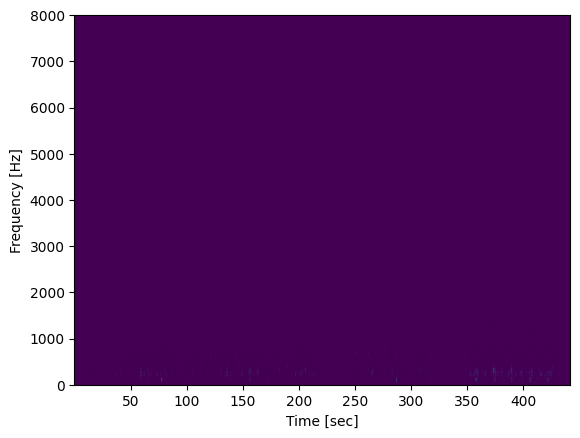

In [76]:
plt.pcolormesh(T, F, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [66]:
Sxx[0].shape

(129, 31558)

In [68]:
np.argmax(Sxx[0], axis=1)

array([26832, 29132, 20537,  9574, 19003, 25619, 30477, 29659, 27970,
       21159, 21084, 15219, 15563, 20861, 14891, 15114, 15448, 15342,
       28993, 15277,  9036, 18870, 15117, 20263, 30475, 29132, 20380,
       21159, 14895, 19559, 14980, 20816, 15450, 10308, 15343, 29134,
       21161,  5413, 19561, 26279, 20863, 20813, 11547, 10306, 20286,
       21159, 29132, 25659, 15219, 20624, 10598, 15344,  9446, 20528,
       20862, 27970, 30268, 15223, 20514, 20813, 22030, 15026, 20215,
       20217, 15276, 15344, 21803, 30265, 20861, 15219, 13259, 26862,
       14891, 21891, 21891, 20432, 15276, 15276, 13099, 10160,  9446,
       20626, 29131, 20762, 21082, 20624, 14183, 26824, 15219, 15343,
       25658, 22030,  4903, 15276, 15114, 20549, 21081, 20862, 27258,
       22030, 15448, 20627, 15342, 14892, 14891, 14892, 30650, 17958,
       25692, 20431, 19559, 15025, 15024, 15114, 29768, 22031, 20861,
       15449, 26824, 21890,  4904, 14701, 14935, 29659, 28388, 15025,
       15342, 19047,